In [200]:
from main import *
import pandas as pd
from matplotlib import pyplot as plt

data = Data("data", "london")

In [201]:
# get station with highest total_lines
data.stations
# get the 5 rows from the dataframe where total_lines is highest
print("Stations with most lines")
data.stations.nlargest(8, "total_lines")


Stations with most lines


,latitude,longitude,name,display_name,zone,total_lines,rail
id,,,,,,,
145,51.5308,-0.1238,King's Cross St. Pancras,King's Cross<br />St. Pancras,1.0,6,1.0
11,51.5226,-0.1571,Baker Street,Baker<br />Street,1.0,5,0.0
13,51.5133,-0.0886,Bank,NaN,1.0,4,0.0
87,51.5074,-0.1223,Embankment,NaN,1.0,4,0.0
156,51.5178,-0.0823,Liverpool Street,Liverpool<br />Street,1.0,4,1.0
167,51.5186,-0.0886,Moorgate,NaN,1.0,4,1.0
193,51.5154,-0.1755,Paddington,NaN,1.0,4,1.0
279,51.5036,-0.1143,Waterloo,NaN,1.0,4,1.0


Stations in each zone


<Axes: xlabel='zone'>

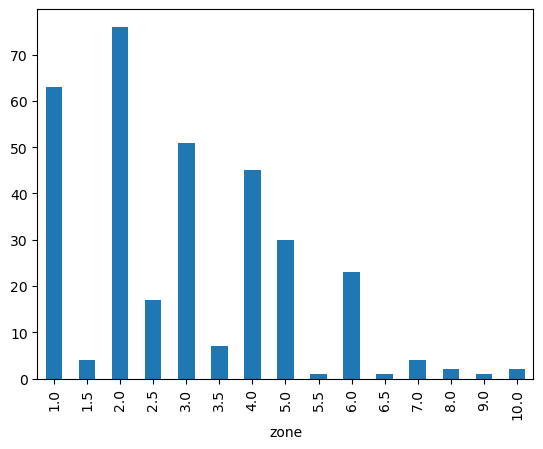

In [202]:
print("Stations in each zone")
data.stations.groupby("zone").size().plot(kind="bar")

Mapping basics

(467004.01124138123, 566478.2566075536, 153561.8369332109, 203919.02440256177)

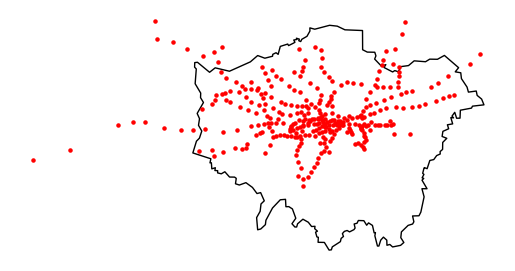

In [203]:
from shapely.geometry import Point
import geopandas

london = geopandas.read_file(os.path.join("mapping", "london_outline_simple.shp"))



# Assuming data.stations is a DataFrame with 'latitude' and 'longitude' columns
geometry = [Point(xy) for xy in zip(data.stations.longitude, data.stations.latitude)]
stations_gdf = geopandas.GeoDataFrame(data.stations, geometry=geometry, crs="EPSG:4326")  # WGS84 latitude-longitude projection

# Convert stations to same CRS as map
stations_gdf = stations_gdf.to_crs(london.crs)

# Now plot the stations on the map
base = london.plot(color='white', edgecolor='black')
stations_gdf.plot(ax=base, marker='o', color='red', markersize=5)
# no axis
plt.axis('off')

(-1.0369691156, 0.39504376560000004, 51.38705, 51.720349999999996)

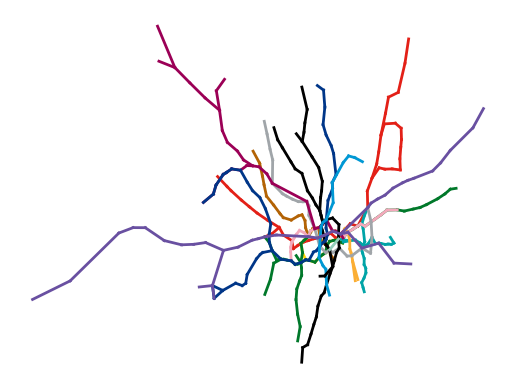

In [204]:
from shapely.geometry import LineString

fig, ax = plt.subplots()

for idx, row in data.connections.iterrows():
    station1 = data.stations.loc[row['station1']]
    start_lat = station1.latitude
    start_lon = station1.longitude
    station2 = data.stations.loc[row['station2']]
    end_lat = station2.latitude
    end_lon = station2.longitude

    # get line colour from data.lines
    line_colour = "#"+data.lines.loc[row['line']]['colour']
    line = LineString([(start_lon, start_lat), (end_lon, end_lat)])
    ax.plot(line.xy[0], line.xy[1], color=line_colour, linewidth=2)

plt.axis('off')


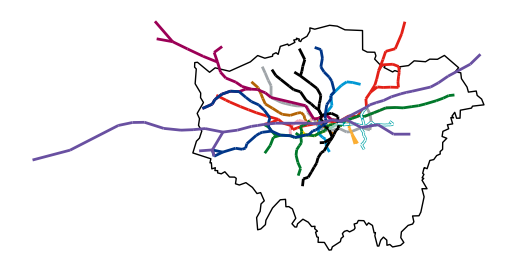

In [205]:
london = geopandas.read_file(os.path.join("mapping", "london_outline_simple.shp"))

# make dict of empty lists for each line
lines_geometry = {line_id: [] for line_id in data.lines.index}


for idx, row in data.connections.iterrows():
    station1 = data.stations.loc[row['station1']]
    start_lat = station1.latitude
    start_lon = station1.longitude
    station2 = data.stations.loc[row['station2']]
    end_lat = station2.latitude
    end_lon = station2.longitude


    line = LineString([(start_lon, start_lat), (end_lon, end_lat)])

    # add line to list for that line
    lines_geometry[row['line']].append(line)

# print(lines_geometry)

base = london.plot(color='white', edgecolor='black')

for line_lines in lines_geometry:
    line_colour = "#"+data.lines.loc[line_lines]['colour']
    stripe = data.lines.loc[line_lines]['stripe']
    line_gdf = geopandas.GeoDataFrame(geometry=lines_geometry[line_lines], crs="EPSG:4326")
    line_gdf = line_gdf.to_crs(london.crs)
    line_gdf.plot(ax=base, color=line_colour, linewidth=2)

    if pd.notna(stripe):
        stripe_colour = "#" + stripe
        line_gdf.plot(ax=base, color=stripe_colour, linewidth=1, linestyle="--")



plt.axis('off')
plt.savefig("map.png", transparent=True, bbox_inches='tight', pad_inches=0)